In [1]:
import os
from os import listdir
from pickle import dump
from pickle import load
from numpy import argmax
from keras.applications.vgg16 import VGG16
from keras_preprocessing.image import load_img
from keras_preprocessing.image import img_to_array
from keras.applications.vgg16 import preprocess_input
from keras.models import Model
import numpy as np
from keras_preprocessing.text import Tokenizer
from collections import Counter
from keras.utils import to_categorical
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Embedding
from keras.layers import Dropout
from keras.layers import add
from keras.layers import concatenate
from keras.utils import plot_model
from keras_preprocessing.sequence import pad_sequences
from keras.models import load_model
import matplotlib.pyplot as plt

In [2]:
import zipfile
from google.colab import drive

drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
caption_train_tokenizer_path = '/content/drive/MyDrive/MVA/DL/caption_train_tokenizer.pkl'
model_path = '/content/drive/MyDrive/MVA/DL/modelConcat_1_5.h5'

Creating captions using pretrained model

In [ ]:
def extract_feature(model, file_name):
    img = load_img(file_name, target_size=(224, 224)) #size is 224,224 by default
    x = img_to_array(img) #change to np array
    x = np.expand_dims(x, axis=0) #expand to include batch dim at the beginning
    x = preprocess_input(x) #make input confirm to VGG16 input format
    fc2_features = model.predict(x)
    return fc2_features

def generate_caption(pred_model, caption_train_tokenizer, photo, max_length):
    in_text = '<START>'
    caption_text = list()
    for i in range(max_length):
            # integer encode input sequence
            sequence = caption_train_tokenizer.texts_to_sequences([in_text])[0]
            # pad input
            sequence = pad_sequences([sequence], maxlen=max_length)
            # predict next word
            model_softMax_output = pred_model.predict([photo,sequence], verbose=0)
            # convert probability to integer
            word_index = argmax(model_softMax_output)
            # map integer to word
            word = caption_train_tokenizer.index_word[word_index]
            #print(word)
            # stop if we cannot map the word
            if word is None:
                break
            # append as input for generating the next word
            in_text += ' ' + word
            # stop if we predict the end of the sequence
            if word != 'end':
                caption_text.append(word)
            if word == 'end':
                break
    return caption_text

def flatten(lst):
    return sum( ([x] if not isinstance(x, list) else flatten(x) for x in lst), [] )

def generate_caption_beam(pred_model, caption_train_tokenizer, photo, max_length, vocab_size, beam_width):
    sequence = caption_train_tokenizer.texts_to_sequences(['<START>'])[0]
    sequence = pad_sequences([sequence], maxlen=max_length)
    model_softMax_output = np.squeeze(pred_model.predict([photo,sequence], verbose=0))
    most_likely_seq=np.argsort(model_softMax_output)[-beam_width:]
    most_likely_prob=np.log(model_softMax_output[most_likely_seq])


    most_likely_cap = list()
    for j in range(beam_width):
        most_likely_cap.append(list())
        most_likely_cap[j] =[[caption_train_tokenizer.index_word[most_likely_seq[j]]]]

    for i in range(max_length):    
        temp_prob = np.zeros((beam_width, vocab_size))
        for j in range(beam_width):
            if most_likely_cap[j][-1] != ['end']: #if not terminated
                num_words = len(most_likely_cap[j])
                sequence = caption_train_tokenizer.texts_to_sequences(most_likely_cap[j])
                sequence = pad_sequences(np.transpose(sequence), maxlen=max_length)
                model_softMax_output = pred_model.predict([photo,sequence], verbose=0)
                temp_prob[j,] = (1/(num_words)) *(most_likely_prob[j]*(num_words-1) + np.log(model_softMax_output)) #update most likily prob
            else:
                temp_prob[j,] = most_likely_prob[j] + np.zeros(vocab_size) - np.inf
                temp_prob[j,0] = most_likely_prob[j]


        x_idx, y_idx = np.unravel_index(temp_prob.flatten().argsort()[-beam_width:], temp_prob.shape)

        most_likely_cap_temp = list()
        for j in range(beam_width):
            most_likely_prob[j] = temp_prob[x_idx[j],y_idx[j]]
            most_likely_cap_temp.append(list())
            most_likely_cap_temp[j] = most_likely_cap[x_idx[j]].copy()
            if most_likely_cap_temp[j][-1] != ['end']:
                most_likely_cap_temp[j].append([caption_train_tokenizer.index_word[y_idx[j]]])

        most_likely_cap = most_likely_cap_temp.copy()

        finished = True
        for j in range(beam_width):
            if most_likely_cap_temp[j][-1] != ['end']:
                finished = False

        if finished == True:
            break

    final_caption = list()

    for j in range(beam_width):
        final_caption.append(' '.join(flatten(most_likely_cap[j][0:-1])))


    return final_caption, most_likely_prob

In [ ]:
base_model = VGG16(include_top=True)
feature_extract_pred_model = Model(inputs=base_model.input, outputs=base_model.get_layer('fc2').output)

553467096/553467096 [==============================] - 4s 0us/step


In [ ]:
caption_train_tokenizer = load(open(caption_train_tokenizer_path, 'rb'))
max_length = 33
pred_model = load_model(model_path) 

Greedy

In [ ]:
# get the path/directory
folder_dir = '/content/drive/MyDrive/MVA/DL/RandomTestingImages'

image_captions_greedy = dict()

for image in os.listdir(folder_dir):
  image_id = image.split('.')[0]
  photo = extract_feature(feature_extract_pred_model, folder_dir+ '/' + image)
  caption = generate_caption(pred_model, caption_train_tokenizer, photo, max_length)
  caption = ' '.join(caption)
  image_captions_greedy[image_id] = caption

1/1 [==============================] - 1s 627ms/step


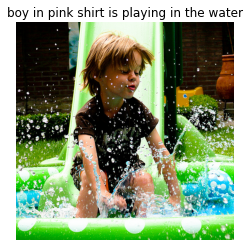

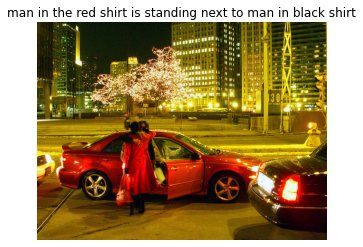

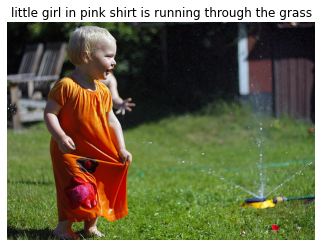

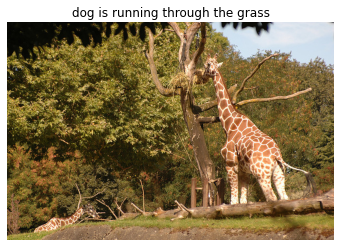

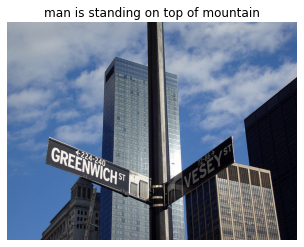

In [ ]:
# Visualisation of results
for image in os.listdir(folder_dir):
  image_id = image.split('.')[0]
  img = plt.imread(folder_dir + '/' + image)
  plt.imshow(img)
  plt.title(image_captions_greedy[image_id])
  plt.axis('off')
  plt.show()

Beam search

In [ ]:
# get the path/directory
folder_dir = '/content/drive/MyDrive/MVA/DL/RandomTestingImages'

vocab_size = 7506
beam_width = 10
max_length = 33

image_captions_beam = dict()

for image in os.listdir(folder_dir):
  image_id = image.split('.')[0]
  photo = extract_feature(feature_extract_pred_model, folder_dir+ '/' + image)
  caption, prob = generate_caption_beam(pred_model, caption_train_tokenizer, photo, max_length,vocab_size,beam_width)
  caption = ''.join(caption[np.argmax(prob)])
  image_captions_beam[image_id] = caption

1/1 [==============================] - 1s 750ms/step


<ipython-input-3-b44174ec1d2a>:60: RuntimeWarning: divide by zero encountered in log
  temp_prob[j,] = (1/(num_words)) *(most_likely_prob[j]*(num_words-1) + np.log(model_softMax_output)) #update most likily prob


1/1 [==============================] - 1s 596ms/step


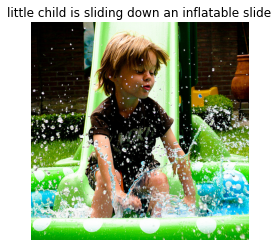

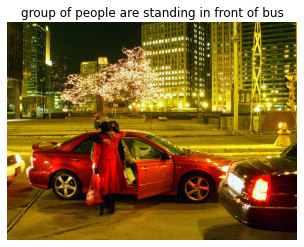

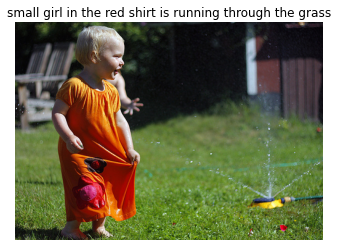

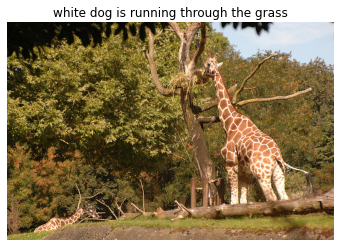

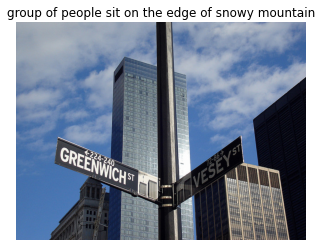

In [ ]:
# Visualisation of results
for image in os.listdir(folder_dir):
  image_id = image.split('.')[0]
  img = plt.imread(folder_dir + '/' + image)
  plt.imshow(img)
  plt.title(image_captions_beam[image_id])
  plt.axis('off')
  plt.show()